<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/gan_credit_card_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 10th Nov, 2023
# Mumbai
# Created by Piyush Kumar <gharonline7@gmail.com> , UBI


In [ ]:
# 1.0
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

# Normalization the dataset
from sklearn.preprocessing import StandardScaler

In [ ]:
# 1.0.1
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# 1.0.2
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Read data and process

In [ ]:
# 2.0
pathToFolder= "/gdrive/MyDrive/Colab_data_files/creditcard/"
file = "creditcardfraud.zip"

In [ ]:
# 2.1 Get the dataframe for Google Driver:

df = pd.read_csv(pathToFolder + file)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# 2.2 Droping Time to simplify:

df.pop('Time')

# 2.3 Separating genuine and fraudulent transactions:

df_g = df.loc[df.Class==0].reset_index(drop=True)
df_f = df.loc[df.Class==1].reset_index(drop=True)

# 2.4 Dropping class column
c0 = df_g.pop('Class')
c1 = df_f.pop('Class')

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

In [ ]:
# 2.4.1
columns = df_g.columns[:-1]
columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [ ]:
# 2.4.2 Count based on the Class Values

df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [ ]:
# 3.0 Scaling data:

s = StandardScaler()
ss.fit(df_g)
df_g = ss.transform(df_g)

StandardScaler()

In [ ]:
# 3.1 Splitting genuine transactions:

X_train , X_valid = df_g[0:-100000], df_g[-100000:]
X_train.shape

In [ ]:
# 3.2 Transform to dataset:

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

## GAN model

In [ ]:
# 4.0
codings_size = 30

# 4.0.1 Generator
generator = tf.keras.models.Sequential(
                                      [
                                        tf.keras.Input(shape = [codings_size]),
                                        tf.keras.layers.Dense(100, activation="selu"),
                                        tf.keras.layers.Dropout(0.5),
                                        tf.keras.layers.Dense(50, activation="selu"),
                                        tf.keras.layers.Dropout(0.5),
                                        tf.keras.layers.Dense(29, activation="linear"),
                                     ]
                                    )

# 4.1 Discriminator:
discriminator = tf.keras.models.Sequential(
                                          [
                                            tf.keras.Input(shape = [29]),
                                            # tf.keras.layers.Flatten(),
                                            tf.keras.layers.Dense(100, activation="selu"),
                                            tf.keras.layers.Dropout(0.5),
                                            tf.keras.layers.Dense(50, activation="selu"),
                                            tf.keras.layers.Dropout(0.5),
                                            tf.keras.layers.Dense(1, activation="sigmoid")
                                          ]
                                        )

In [ ]:
# 4.2
gan = tf.keras.models.Sequential([generator, discriminator])

In [ ]:
# 4.3
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_data = generator(noise)
print(type(generated_data))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
# 4.4
for x_batch in dataset:
  # print(type(x_batch))
  a= x_batch
  break

In [ ]:
# 5.0 Changing the type of data:

generate_data = tf.cast(generated_data, tf.float32)
a = tf.cast(a, tf.float32)
tf.concat([generated_data, a], axis=0)


<tf.Tensor: shape=(64, 29), dtype=float32, numpy=
array([[ 2.2480245 ,  0.28280172, -0.6251417 , ..., -1.5471988 ,
        -1.3258225 , -0.7047256 ],
       [ 1.624276  , -1.081154  , -1.0328873 , ..., -2.1713748 ,
        -1.1927168 ,  0.49651548],
       [-0.0085402 , -0.34554666, -0.3663266 , ..., -0.66648227,
        -0.8413478 ,  1.0522336 ],
       ...,
       [-0.313758  ,  0.5521427 ,  0.5158516 , ..., -0.11210094,
         0.1881958 , -0.31303304],
       [-0.49291396,  1.1116666 ,  1.439321  , ...,  0.7844685 ,
         0.74897224, -0.34214085],
       [ 0.60911185,  0.09150644,  0.15523025, ...,  0.08768185,
         0.03557099, -0.30719548]], dtype=float32)>

In [ ]:
# 5.1
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="adam")

In [ ]:
# 6.0
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers #Gan Consist of Two Layers will give two outputs
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_data = generator(noise)

            generated_data = tf.cast(generated_data,tf.float32)
            X_batch = tf.cast(X_batch,tf.float32)

            X_fake_and_real = tf.concat([generated_data, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size) # label 32 images as 1
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

        new_df = pd.DataFrame(ss.inverse_transform(generated_data), columns=columns)
        print(new_df[-5:].head(10))
        # plt.show()

In [ ]:
# 6.1 Begin training:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=4)

Epoch 1/4
          V1        V2        V3        V4        V5        V6        V7  \
27  0.369358 -0.355090  0.788392 -0.928476 -0.568768  0.073096 -0.748958   
28 -1.467031  0.110385  2.763885 -0.661164 -0.236986  1.689788 -0.420120   
29 -4.761889  1.588198  2.556786 -0.368618  1.122524 -0.510495  0.963894   
30  0.734975 -1.430462  0.701834 -0.210543 -0.762275  1.464190 -1.804408   
31 -0.917833  0.959588  1.300837 -0.199832 -0.415226 -1.710691 -0.303237   

          V8        V9       V10  ...       V20       V21       V22       V23  \
27  0.684269  0.773031 -0.743642  ... -0.133745  0.042158 -0.286271  0.302398   
28  0.586489  0.890528 -1.494826  ... -0.208905 -0.258754 -1.028445  0.401345   
29  0.550899  0.582473 -1.928367  ...  0.012984 -0.382705 -0.686956 -0.073716   
30  0.570778  1.630913 -0.329881  ... -0.797883 -0.036896 -0.657956  0.496036   
31 -0.188121 -0.568851  0.036977  ... -0.053286  0.378353 -0.210515 -0.621441   

         V24       V25       V26       V27    

## Generate fake data

In [ ]:
# 7.0
noise = tf.random.normal(shape=[X_train.shape[0],30])
generate_data = generator(noise)
gd = pd.DataFrame(generate_data, columns=columns)

In [ ]:
# 7.1 Comparing the Normalized Amount =====>  of Generate Data and X_train Data

(array([ 26646., 127580.,  15339.,   5818.]),
 array([-1. , -0.5,  0. ,  0.5,  1. ]),
 <BarContainer object of 4 artists>)

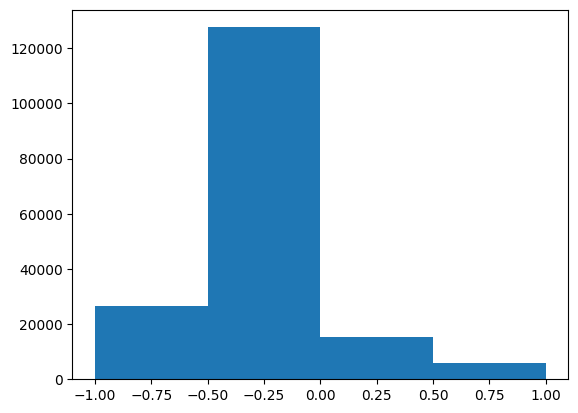

In [ ]:
plt.hist(gd.iloc[:,-1],bins=[-1,-0.5,0,0.5,1])

(array([     0., 142251.,  24547.,   7332.]),
 array([-1. , -0.5,  0. ,  0.5,  1. ]),
 <BarContainer object of 4 artists>)

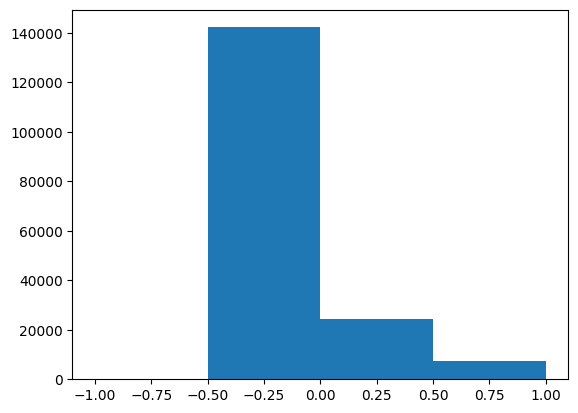

In [ ]:
# 7.2
plt.hist(X_train[:,-1], bins=[-1,-0.5,0,0.5,1])

In [ ]:
#########################